# Parametrized DNN
parametrized DNN 
1. Include all signals
2. check the backgrounds.
3. Check the AUC score as this is coming 1
4. Improve the training
5. include the weight of preselection

[INFO] Model & scaler loaded on cuda. Features: 41
[INFO] Scored 48 events | mean=0.233, std=0.141


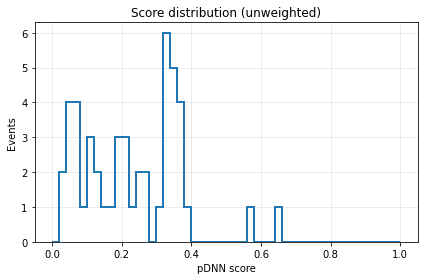

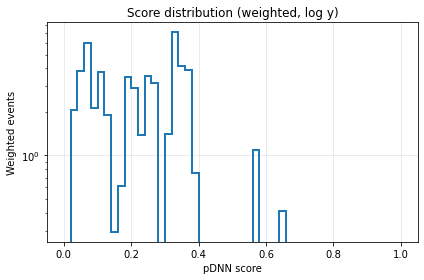

[NOTE] No 'label' column (or single class) → showing overall score only.


In [1]:
# ===== Minimal one-cell: load model, score ONE parquet, plot =====
import os, json, pickle, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings("ignore", category=UserWarning)

# ---- set THIS path ----
SAMPLE_PATH = "../../../output_root/v3_production/samples/postEE/QCD_PT-30To40.parquet"   # ← change this
mass_const, y_const = 600, 100          # used only if file lacks 'mass','y_value'

# ---- artifact paths (same folder as training outputs) ----
SAVE_MODEL_PATH = "best_pdnn.pt"
SCALER_PATH     = "scaler.pkl"
FEATLIST_PATH   = "features_used.json"
WEIGHT_COL      = "weight_central"

# ---- simple plot style ----
plt.rcParams.update({"figure.figsize": (7.5,5.5), "axes.grid": True, "grid.alpha": 0.3})

# === feature helpers (same as training) ===
def ensure_photon_mva_columns(df):
    for want, alt in [("lead_mvaID_run3","lead_mvaID_nano"),
                      ("sublead_mvaID_run3","sublead_mvaID_nano")]:
        if want not in df.columns and alt in df.columns:
            df[want] = df[alt]
    return df

def add_engineered_features(df):
    mHH = df.get("Res_HHbbggCandidate_mass", pd.Series(index=df.index, dtype="float32")).replace(0, np.nan)
    df["ptjj_over_mHH"]  = (df["Res_dijet_pt"] / mHH) if "Res_dijet_pt" in df.columns else 0.0
    df["ptHH_over_mHH"]  = (df["Res_HHbbggCandidate_pt"] / mHH) if "Res_HHbbggCandidate_pt" in df.columns else 0.0
    if all(c in df.columns for c in ["lead_phi","sublead_phi","lead_eta","sublead_eta"]):
        dphi = np.abs(df["lead_phi"] - df["sublead_phi"]); dphi = np.where(dphi > np.pi, 2*np.pi - dphi, dphi)
        df["DeltaR_gg"] = np.sqrt((df["lead_eta"]-df["sublead_eta"])**2 + dphi**2)
    else:
        df["DeltaR_gg"] = 0.0
    for c in ["Res_CosThetaStar_gg","Res_CosThetaStar_jj","Res_CosThetaStar_CS"]:
        if c in df.columns: df[c] = df[c].abs()
    for c in ["ptjj_over_mHH","ptHH_over_mHH","DeltaR_gg"]:
        df[c] = df[c].fillna(0)
    return df

def ensure_weight(df, weight_col=WEIGHT_COL):
    if weight_col not in df.columns: df[weight_col] = 1.0
    return df

# === model (exact layout as training; BN placeholders kept as Identity) ===
def maybe_bn(_): return nn.Identity()  # USE_BATCHNORM=False
class ParameterizedDNN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d,128), maybe_bn(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128,64), maybe_bn(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64,32),  maybe_bn(32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32,1)
        )
    def forward(self, x): return self.net(x)

@torch.no_grad()
def predict_batched(model, X, device, batch=32768):
    model.eval(); N = X.shape[0]; out = np.empty(N, dtype=np.float32)
    amp = torch.amp.autocast(device_type=device.type, enabled=(device.type=="cuda"))
    with amp:
        for i in range(0, N, batch):
            xb = X[i:i+batch].to(device, non_blocking=True)
            out[i:i+batch] = torch.sigmoid(model(xb).view(-1)).detach().cpu().numpy()
    return out

# === load artifacts ===
with open(FEATLIST_PATH, "r") as f: FEATURES = json.load(f)["features"]
with open(SCALER_PATH, "rb") as f: scaler = pickle.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ParameterizedDNN(len(FEATURES)).to(device)
try:
    state = torch.load(SAVE_MODEL_PATH, map_location=device, weights_only=True)
except TypeError:
    state = torch.load(SAVE_MODEL_PATH, map_location=device)
model.load_state_dict(state); model.eval()
print(f"[INFO] Model & scaler loaded on {device}. Features: {len(FEATURES)}")

# === read parquet → features → scale → score ===
assert os.path.exists(SAMPLE_PATH), f"Missing file: {SAMPLE_PATH}"
df = pd.read_parquet(SAMPLE_PATH)
df = ensure_photon_mva_columns(df)
df = add_engineered_features(df)
df = ensure_weight(df)
if "mass" not in df.columns:    df["mass"] = mass_const     # backgrounds/data: inject constants
if "y_value" not in df.columns: df["y_value"] = y_const

missing = [f for f in FEATURES if f not in df.columns]
if missing: raise RuntimeError(f"Missing required features: {missing[:10]}{'...' if len(missing)>10 else ''}")

X = df[FEATURES].copy().fillna(df[FEATURES].mean(numeric_only=True)).values
X = scaler.transform(X)
scores = predict_batched(model, torch.tensor(X, dtype=torch.float32), device)
w = df[WEIGHT_COL].astype("float32").values if WEIGHT_COL in df.columns else np.ones_like(scores)

print(f"[INFO] Scored {len(scores):,} events | mean={scores.mean():.3f}, std={scores.std():.3f}")

# === plots ===
bins = np.linspace(0.0, 1.0, 51)

plt.figure()
plt.hist(scores, bins=bins, histtype="step", linewidth=2.0)
plt.xlabel("pDNN score"); plt.ylabel("Events")
plt.title("Score distribution (unweighted)"); plt.tight_layout(); plt.show()

plt.figure()
plt.hist(scores, bins=bins, weights=w, histtype="step", linewidth=2.0)
plt.yscale("log"); plt.xlabel("pDNN score"); plt.ylabel("Weighted events")
plt.title("Score distribution (weighted, log y)"); plt.tight_layout(); plt.show()

# If labels exist, also draw S/B shapes + ROC
if "label" in df.columns and df["label"].nunique()==2:
    y = df["label"].astype(int).values
    s, b = (y==1), (y==0)
    plt.figure()
    plt.hist(scores[s], bins=bins, density=True, histtype="step", linewidth=2.0, label="Signal")
    plt.hist(scores[b], bins=bins, density=True, histtype="step", linewidth=2.0, label="Background")
    plt.xlabel("pDNN score"); plt.ylabel("Density")
    plt.title("Signal vs Background (shape)"); plt.legend(); plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(y, scores, sample_weight=w)
    A = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {A:.3f}")
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlabel("Background efficiency"); plt.ylabel("Signal efficiency")
    plt.title("ROC"); plt.legend(); plt.tight_layout(); plt.show()
    print(f"[INFO] ROC AUC = {A:.4f}")
else:
    print("[NOTE] No 'label' column (or single class) → showing overall score only.")


In [2]:
# add the scores as a new column
df_out = df.copy()
df_out["pdnn_score"] = scores.astype("float32")

# choose output file + tree name
out_root = "pDNN_Score.root"
tree_name = "Events"   # you can pick any

# write to ROOT
with uproot.recreate(out_root) as fout:
    fout[tree_name] = df_out

print(f"[INFO] wrote {len(df_out):,} events with pdnn_score → {out_root}:{tree_name}")


NameError: name 'uproot' is not defined

# Reading complete folder

[INFO] Scoring samples:
  -                 Data_EraE  (data)
  -                 Data_EraF  (data)
  -                 Data_EraG  (data)
  -                    GGJets  (bkg)
  -              GJetPt20To40  (bkg)
  -                  GJetPt40  (bkg)
  -               GluGluHToGG  (bkg)
  -           NMSSM_X500_Y150  (signal)
  -                  VBFHToGG  (bkg)
  -                    VHToGG  (bkg)
  -                   ttHToGG  (bkg)


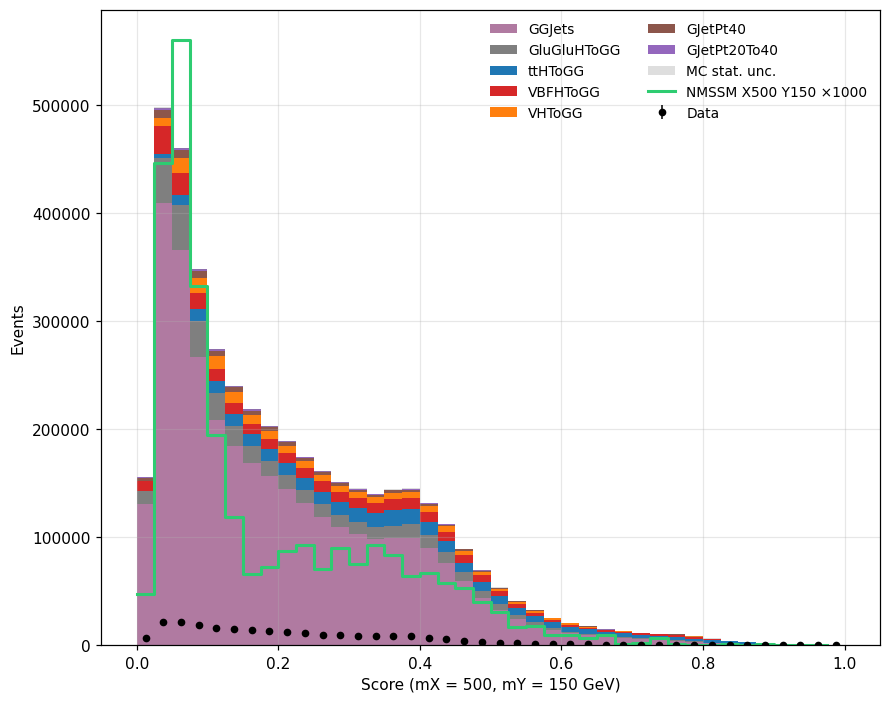

In [2]:
# === Stack plot: Data vs MC with CMS-like palette and robustness for missing features ===
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch  # used below in read_and_score

FOLDER = "../../../output_root/v3_production/samples/pDNN_score/"
BINS   = np.linspace(0.0, 1.0, 41)
MASS_CONST, Y_CONST = 600, 100
SHAPE_ONLY = False        # True => normalize total MC to data (debugging)
SIGNAL_SCALE = 1000.0        # multiply signal line
SAVE_FIG = "stack_DataVsMC_pDNN.png"

# CMS-like colors to match your reference figure
COLORS = {
    "ttHToGG": "#1f77b4",      # blue
    "VHToGG":  "#ff7f0e",      # orange
    "VBFHToGG":"#d62728",      # red
    "GluGluHToGG":"#7f7f7f",   # gray (ggH)
    "GJetPt20To40":"#9467bd",  # purple (γ+jets low pT)
    "GJetPt40":    "#8c564b",  # brown (γ+jets high pT)
    "GGJets":      "#b07aa1",  # lavender (γγ+jets)
}

SIG_COLOR  = "#2ecc71"  # green line
DATA_FMT   = dict(fmt="o", ms=4, lw=1, color="k")

def short_name(path): 
    return os.path.splitext(os.path.basename(path))[0]

def classify(base):
    if base.lower().startswith("data_"): 
        return "data"
    if base.startswith("NMSSM_"):        
        return "signal"
    return "bkg"

def parse_signal_xy(base):
    m = re.search(r"NMSSM_X(\d+)_Y(\d+)", base)
    return (int(m.group(1)), int(m.group(2))) if m else (MASS_CONST, Y_CONST)

def read_and_score(fp, mass_const=MASS_CONST, y_const=Y_CONST):
    df = pd.read_parquet(fp)

    # nano fallbacks
    for want, alt in [("lead_mvaID_run3","lead_mvaID_nano"),
                      ("sublead_mvaID_run3","sublead_mvaID_nano")]:
        if want not in df.columns and alt in df.columns:
            df[want] = df[alt]

    # engineered + weights (provided by your analysis code)
    df = add_engineered_features(df)
    df = ensure_weight(df)

    # constants if missing
    if "mass" not in df.columns:    
        df["mass"] = mass_const
    if "y_value" not in df.columns: 
        df["y_value"] = y_const

    # ensure all model features exist (fill missing with 0.0)
    for f in FEATURES:
        if f not in df.columns:
            df[f] = 0.0

    # scale + predict
    X = df[FEATURES].copy().fillna(df[FEATURES].mean(numeric_only=True)).values
    X = scaler.transform(X)
    scores = predict_batched(model, torch.tensor(X, dtype=torch.float32), device)

    # weights
    w = (df[WEIGHT_COL].astype("float32").values 
         if WEIGHT_COL in df.columns else np.ones_like(scores, dtype="float32"))
    return scores.astype("float32"), w

# discover files
files = sorted(glob.glob(os.path.join(FOLDER, "*.parquet")))
assert files, f"No parquet files found in {FOLDER}"

bkg_hists = []
data_counts = None
signal_counts = None
edges = BINS
sig_mx, sig_my, sig_label = MASS_CONST, Y_CONST, None

print("[INFO] Scoring samples:")
for fp in files:
    base = short_name(fp)
    kind = classify(base)
    print(f"  - {base:>25s}  ({kind})")

    if kind == "signal":
        mx, my = parse_signal_xy(base)
        sig_mx, sig_my = mx, my
        sig_label = base.replace("_"," ")
        scores, w = read_and_score(fp, mass_const=mx, y_const=my)
        sc, ed = np.histogram(scores, bins=BINS, weights=w); edges = ed
        signal_counts = (sc * SIGNAL_SCALE).astype("float64")

    elif kind == "data":
        scores, _ = read_and_score(fp, mass_const=MASS_CONST, y_const=Y_CONST)
        sc, ed = np.histogram(scores, bins=BINS, weights=np.ones_like(scores)); edges = ed
        data_counts = sc.astype("float64") if data_counts is None else data_counts + sc

    else:  # background
        scores, w = read_and_score(fp, mass_const=MASS_CONST, y_const=Y_CONST)
        sc, ed = np.histogram(scores, bins=BINS, weights=w); edges = ed
        color = "#95a5a6"
        for key, c in COLORS.items():
            if key in base:
                color = c; break
        bkg_hists.append((base, sc.astype("float64"), color))

# order backgrounds by yield descending (nicer stack)
if bkg_hists:
    bkg_hists.sort(key=lambda t: t[1].sum(), reverse=True)
    bkg_sum = sum((sc for _, sc, _ in bkg_hists), np.zeros_like(bkg_hists[0][1], dtype="float64"))
else:
    bkg_sum = np.zeros_like(edges[:-1], dtype="float64")

bin_centers = 0.5*(edges[:-1]+edges[1:])

# optional shape-only normalization
if SHAPE_ONLY and data_counts is not None and bkg_sum.sum() > 0:
    scale = data_counts.sum() / bkg_sum.sum()
    bkg_sum *= scale
    bkg_hists = [(lbl, sc*scale, col) for (lbl, sc, col) in bkg_hists]
    if signal_counts is not None:
        signal_counts = signal_counts * scale

# MC stat error band (use sumw2 if available in your pipeline)
mc_err = np.sqrt(np.maximum(bkg_sum, 1.0))

# ------------- plot (single axis; no ratio box) -------------
fig, ax = plt.subplots(figsize=(8.2, 6.5), dpi=110)

# stack
if bkg_hists:
    ax.hist([bin_centers]*len(bkg_hists), bins=edges,
            weights=[sc for _, sc, _ in bkg_hists],
            histtype="barstacked",
            color=[col for _, _, col in bkg_hists],
            label=[lbl for lbl, _, _ in bkg_hists],
            linewidth=0.0)

# MC stat band
ax.fill_between(bin_centers, bkg_sum - mc_err, bkg_sum + mc_err,
                step="mid", alpha=0.25, color="#7f7f7f", linewidth=0, label="MC stat. unc.")

# data points
if data_counts is not None:
    y = data_counts
    yerr = np.sqrt(np.maximum(y, 1.0))
    ax.errorbar(bin_centers, y, yerr=yerr, **DATA_FMT, label="Data")

# signal overlay
if signal_counts is not None:
    ax.step(edges[:-1], signal_counts, where="post", color=SIG_COLOR, lw=2.0,
            label=(sig_label if SIGNAL_SCALE == 1.0 else f"{sig_label} ×{SIGNAL_SCALE:g}"))

# labels, legend, cosmetics
ax.set_ylabel("Events")
xlabel = "Score" if sig_label is None else f"Score (mX = {sig_mx}, mY = {sig_my} GeV)"
ax.set_xlabel(xlabel)
ax.legend(ncol=2, fontsize=9, frameon=False)
ax.grid(True, axis="y", alpha=0.3)
# ax.set_yscale("log")  # uncomment for log scale

plt.tight_layout()
if SAVE_FIG:
    plt.savefig(SAVE_FIG, bbox_inches="tight")
plt.show()


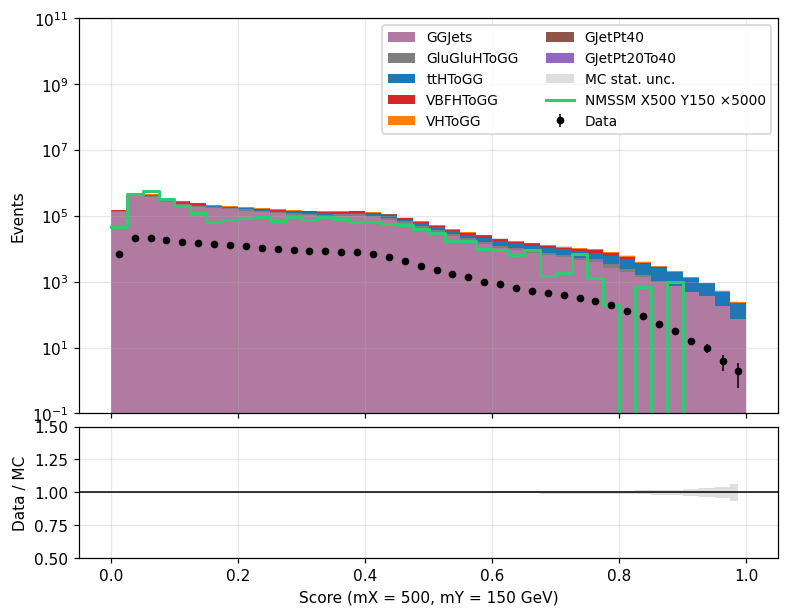

In [3]:
# ------------- plot with Data/MC ratio -------------
import numpy as np
import matplotlib.pyplot as plt
SIGNAL_SCALE = 5000.0  # or 5000. try a few


fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(8.2, 6.5), dpi=110,
    gridspec_kw={"height_ratios": [3.0, 1.0], "hspace": 0.05},
    sharex=True,
)

# ----- top panel: stacked MC + data + signal -----
if bkg_hists:
    ax.hist([bin_centers]*len(bkg_hists), bins=edges,
            weights=[sc for _, sc, _ in bkg_hists],
            histtype="barstacked",
            color=[col for _, _, col in bkg_hists],
            label=[lbl for lbl, _, _ in bkg_hists],
            linewidth=0.0)

# MC stat band (top)
ax.fill_between(bin_centers, bkg_sum - mc_err, bkg_sum + mc_err,
                step="mid", alpha=0.25, color="#7f7f7f", linewidth=0, label="MC stat. unc.")

# data points
if data_counts is not None:
    y = data_counts
    yerr = np.sqrt(np.maximum(y, 1.0))
    ax.errorbar(bin_centers, y, yerr=yerr, **DATA_FMT, label="Data")

# signal overlay
if signal_counts is not None:
    ax.step(edges[:-1], signal_counts, where="post", color=SIG_COLOR, lw=2.0,
            label=(sig_label if SIGNAL_SCALE == 1.0 else f"{sig_label} ×{SIGNAL_SCALE:g}"))

# cosmetics (top)
ax.set_ylabel("Events")
xlabel = "Score" if sig_label is None else f"Score (mX = {sig_mx}, mY = {sig_my} GeV)"
ax.set_yscale("log")
ax.set_ylim(1e-1, 1e11)  # from 10^-1 to 10^11
ax.grid(True, axis="y", alpha=0.3)

# legend inside plot with a box
ax.legend(
    ncol=2, fontsize=9, frameon=True, fancybox=True, framealpha=0.85,
    loc="upper right"   # try "upper left" if it overlaps your points
)

# ----- bottom panel: Data/MC ratio -----
mc_safe = np.where(bkg_sum > 0.0, bkg_sum, np.nan)  # NaN for empty MC bins

with np.errstate(invalid="ignore", divide="ignore"):
    ratio = data_counts / mc_safe
    ratio_err = np.sqrt(np.maximum(data_counts, 1.0)) / mc_safe
    rel_mc = mc_err / mc_safe

# MC relative uncertainty band in ratio
rax.fill_between(bin_centers, 1 - rel_mc, 1 + rel_mc,
                 step="mid", alpha=0.25, color="#7f7f7f", linewidth=0)

# data ratio points
rax.errorbar(bin_centers, ratio, yerr=ratio_err, **DATA_FMT)

# cosmetics (bottom)
rax.axhline(1.0, color="k", lw=1)
rax.set_ylabel("Data / MC")
rax.set_xlabel(xlabel)
rax.set_ylim(0.5, 1.5)  # adjust to taste
rax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
if SAVE_FIG:
    plt.savefig(SAVE_FIG, bbox_inches="tight")
plt.show()


In [4]:
print("Yield check:")
print("  total background =", float(bkg_sum.sum()))
print("  data             =", float(data_counts.sum()) if data_counts is not None else None)
print("  signal           =", float(signal_counts.sum()) if signal_counts is not None else None)
print("Background components:")
for lbl, sc, _ in bkg_hists:
    print(f"   {lbl:20s} {sc.sum():.3g}")

# Ensure no signal sample slipped into background list
assert all("NMSSM" not in lbl for lbl, _, _ in bkg_hists), "Signal ended up in background stack!"


Yield check:
  total background = 4324365.970397949
  data             = 231358.0
  signal           = 2824533.169921875
Background components:
   GGJets               3.21e+06
   GluGluHToGG          3.56e+05
   ttHToGG              2.69e+05
   VBFHToGG             2.49e+05
   VHToGG               1.47e+05
   GJetPt40             7.26e+04
   GJetPt20To40         1.87e+04


In [5]:
print("Mean pDNN score:")
print("  signal =", float(np.average(bin_centers, weights=signal_counts)) if signal_counts is not None else None)
print("  bkg    =", float(np.average(bin_centers, weights=bkg_sum)))


Mean pDNN score:
  signal = 0.1775938469724985
  bkg    = 0.2160740827694711


In [6]:
print(f"Signal parsed masses: mX={sig_mx}, mY={sig_my}")


Signal parsed masses: mX=500, mY=150


In [7]:
def predict_batched(model, X_torch, device):
    model.eval()
    with torch.no_grad():
        out = model(X_torch.to(device))

        # --- choose the right head/activation ---
        if out.ndim == 1 or out.shape[1] == 1:
            # Binary head: logits for "signal". Apply sigmoid.
            # If your training used BCEWithLogitsLoss(target: 1=signal, 0=bkg)
            score = torch.sigmoid(out).squeeze(1 if out.ndim==2 else 0)

        elif out.shape[1] == 2:
            # Two-class head: logits [bkg, sig] or [sig, bkg]
            # Most PyTorch trainings use class index order passed to the dataloader.
            # If you trained with targets 0=bkg, 1=sig, then p(signal)=softmax(...)[...,1]
            prob = torch.softmax(out, dim=1)
            score = prob[:, 1]      # <-- take the SIGNAL column

            # If your training label order was 0=signal, 1=background, use prob[:, 0] instead.

        else:
            raise ValueError("Unexpected model output shape")

    return score.cpu().numpy()


In [8]:
scores = predict_batched(model, torch.tensor(X, dtype=torch.float32), device)
# If signal still sits at low x after plotting, do:
# scores = 1.0 - scores


In [9]:
# Mean score (signal should be larger than background)
sig_mean = np.average(bin_centers, weights=signal_counts) if signal_counts is not None else None
bkg_mean = np.average(bin_centers, weights=bkg_sum)
print(f"mean(score)  signal={sig_mean:.3f}  bkg={bkg_mean:.3f}")


mean(score)  signal=0.178  bkg=0.216


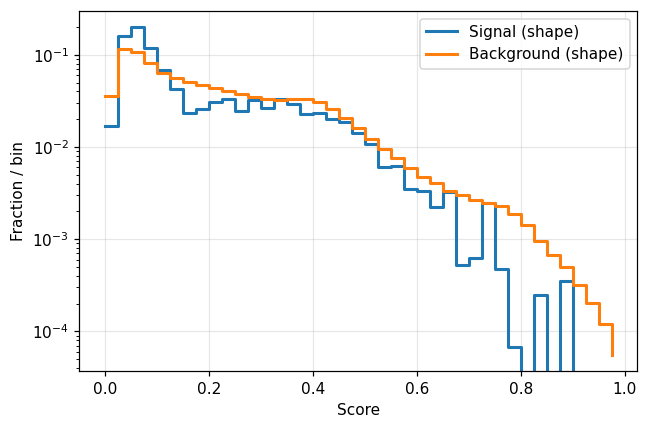

In [10]:
def _unit(h): 
    s = h.sum() 
    return h/s if s>0 else h

sig_shape = _unit(signal_counts)
bkg_shape = _unit(bkg_sum)

plt.figure(figsize=(6,4), dpi=110)
plt.step(edges[:-1], sig_shape, where="post", lw=2, label="Signal (shape)",)
plt.step(edges[:-1], bkg_shape, where="post", lw=2, label="Background (shape)")
plt.yscale("log"); plt.xlabel("Score"); plt.ylabel("Fraction / bin")
plt.legend(); plt.tight_layout()


In [11]:
for f in FEATURES:
    if f not in df.columns:
        df[f] = 0.0
X = df[FEATURES].copy().fillna(df[FEATURES].mean(numeric_only=True)).values
X = scaler.transform(X)


In [12]:
# Build a per-feature default using the training scaler/imputer
def training_default_map(FEATURES, scaler, imputer=None):
    defaults = {}
    for i, f in enumerate(FEATURES):
        if imputer is not None:
            defaults[f] = imputer.statistics_[i]
        elif hasattr(scaler, "mean_"):
            defaults[f] = float(scaler.mean_[i])   # raw mean used in training
        else:
            defaults[f] = 0.0
    return defaults

DEFAULTS = training_default_map(FEATURES, scaler, imputer=None)  # plug your imputer if you used one

def prepare_X(df):
    # Create any missing columns using training defaults
    for f in FEATURES:
        if f not in df.columns:
            df[f] = DEFAULTS[f]
    # Fill NaNs with training defaults (not per-file means)
    df[FEATURES] = df[FEATURES].fillna({f: DEFAULTS[f] for f in FEATURES})
    # Preserve training feature order
    X = df[FEATURES].values.astype("float32", copy=False)
    # Apply the exact training scaler
    return scaler.transform(X).astype("float32", copy=False)


In [13]:
X = prepare_X(df)
scores = predict_batched(model, torch.tensor(X, dtype=torch.float32), device)
scores

array([0.259229  , 0.38014814, 0.37073624, 0.36904818, 0.17289998,
       0.30918604, 0.35122985, 0.12947185, 0.10125723, 0.328949  ,
       0.3777113 , 0.0874256 , 0.26627424, 0.07468633, 0.20494509,
       0.5715578 , 0.38019627, 0.04435955, 0.32921767, 0.05171861,
       0.10880734, 0.20684388, 0.10616941, 0.23579301, 0.12747742,
       0.06866965, 0.19746536, 0.33527553, 0.2783353 , 0.66068053,
       0.33891234, 0.07213102, 0.1589002 , 0.0383295 , 0.040985  ,
       0.34474197, 0.33250177, 0.20743549, 0.18331838, 0.34009063,
       0.2507623 , 0.1955536 , 0.03188077, 0.32933104, 0.35095534,
       0.07243036, 0.34700027, 0.05968913], dtype=float32)

In [14]:
def predict_batched(model, X_torch, device):
    model.eval()
    with torch.no_grad():
        out = model(X_torch.to(device))
        if out.ndim == 1 or out.shape[1] == 1:
            score = torch.sigmoid(out).reshape(-1)
        elif out.shape[1] == 2:
            prob = torch.softmax(out, dim=1)
            score = prob[:, 1]  # <-- signal class index (adjust if you trained 0=signal)
        else:
            raise ValueError(f"Unexpected output shape {tuple(out.shape)}")
    return score.detach().cpu().numpy().clip(0, 1)


In [15]:
mx, my = parse_signal_xy(base)
if mx is None or my is None:
    raise ValueError(f"Could not parse masses from {base}; refusing to fall back silently.")
df["mass"] = mx; df["y_value"] = my


In [16]:
def summarize_scores(name, s, w=None):
    import numpy as np
    if w is None: w = np.ones_like(s)
    print(f"[{name}]  mean={np.average(s, weights=w):.3f}  "
          f"p90={np.quantile(s, 0.90):.3f}  p99={np.quantile(s, 0.99):.3f}  "
          f">0.9={(w[s>0.9].sum()/w.sum()):.3%}")

# call for each sample type
# summarize_scores("signal", scores_sig, w_sig)
# summarize_scores("bkg", scores_bkg, w_bkg)


In [ ]:
# === Add pDNN_score to each parquet and save to a new "scored/" subfolder ===
import os, re, glob
import numpy as np
import pandas as pd
import torch

# --------- Paths / constants ---------
IN_FOLDER  = "../../../output_root/v3_production/samples/preEE/"
OUT_FOLDER = os.path.join(IN_FOLDER, "scored")   # outputs go here (originals untouched)
os.makedirs(OUT_FOLDER, exist_ok=True)

MASS_CONST, Y_CONST = 600, 100

# Inference controls (tune if needed)
BATCH_SIZE = 65536     # lower if you still hit OOM (e.g., 32768 or 16384)
USE_AMP    = True      # mixed precision on CUDA to reduce memory

# --------- Assumed available in your environment ---------
# - FEATURES: list[str] of model input feature names
# - add_engineered_features(df): adds engineered columns used by the model
# - ensure_weight(df): ensures weight column exists (ok to keep even if unused here)
# - scaler: fitted scaler with .transform(...)
# - model: torch model ready for eval
# - device: torch.device("cuda") or torch.device("cpu")
# ---------------------------------------------------------

def short_name(path):
    return os.path.splitext(os.path.basename(path))[0]

def classify(base):
    if base.lower().startswith("data_"): return "data"
    if base.startswith("NMSSM_"):        return "signal"
    return "bkg"

def parse_signal_xy(base, default_m=MASS_CONST, default_y=Y_CONST):
    m = re.search(r"NMSSM_X(\d+)_Y(\d+)", base)
    return (int(m.group(1)), int(m.group(2))) if m else (default_m, default_y)

def read_and_score_for_saving(fp, mass_const=MASS_CONST, y_const=Y_CONST):
    df = pd.read_parquet(fp)

    # Handle possible NanoAOD fallbacks
    for want, alt in [("lead_mvaID_run3", "lead_mvaID_nano"),
                      ("sublead_mvaID_run3", "sublead_mvaID_nano")]:
        if want not in df.columns and alt in df.columns:
            df[want] = df[alt]

    # Keep your pipeline steps so the model inputs are consistent
    df = add_engineered_features(df)
    df = ensure_weight(df)

    # Fill constants if missing
    if "mass" not in df.columns:
        df["mass"] = mass_const
    if "y_value" not in df.columns:
        df["y_value"] = y_const

    # Ensure all model features exist
    for f in FEATURES:
        if f not in df.columns:
            df[f] = 0.0

    # ----- SCALE + PREDICT IN MINI-BATCHES (GPU-safe) -----
    X = df[FEATURES].copy().fillna(df[FEATURES].mean(numeric_only=True)).values
    X = scaler.transform(X).astype("float32", copy=False)

    n = X.shape[0]
    scores = np.empty(n, dtype="float32")

    model.eval()
    is_cuda = (hasattr(device, "type") and device.type == "cuda")

    with torch.no_grad():
        for i in range(0, n, BATCH_SIZE):
            xb_np = X[i:i+BATCH_SIZE]
            xb = torch.from_numpy(xb_np)

            if is_cuda:
                xb = xb.to(device, non_blocking=True)

            if is_cuda and USE_AMP:
                with torch.cuda.amp.autocast():
                    out = model(xb)
            else:
                out = model(xb)

            scores[i:i+BATCH_SIZE] = out.squeeze().detach().float().cpu().numpy()

            # free ASAP
            del xb, out
            if is_cuda:
                torch.cuda.empty_cache()

    df["pDNN_score"] = scores
    return df

# --------- Main ---------
files = sorted(glob.glob(os.path.join(IN_FOLDER, "*.parquet")))
assert files, f"No parquet files found in {IN_FOLDER}"

print(f"[INFO] Found {len(files)} parquet files")
print(f"[INFO] Output directory: {OUT_FOLDER}")

for fp in files:
    base = short_name(fp)
    kind = classify(base)
    mx, my = parse_signal_xy(base)

    print(f"  - {base:>25s}  ({kind}) -> adding 'pDNN_score'")

    df = read_and_score_for_saving(
        fp,
        mass_const=mx if kind == "signal" else MASS_CONST,
        y_const=my if kind == "signal" else Y_CONST
    )

    out_fp = os.path.join(OUT_FOLDER, f"{base}.parquet")

    # atomic-ish write
    tmp_fp = out_fp + ".tmp"
    df.to_parquet(tmp_fp, index=False)
    os.replace(tmp_fp, out_fp)

print(f"[INFO] Done. Scored files saved in: {OUT_FOLDER}")


[INFO] Found 14 parquet files
[INFO] Output directory: ../../../output_root/v3_production/samples/preEE/scored
  -                2022_DataC  (bkg) -> adding 'pDNN_score'
  -                2022_DataD  (bkg) -> adding 'pDNN_score'
  - 2022_preEE_DDQCDGJET_Rescaled  (bkg) -> adding 'pDNN_score'
  - 2022_preEE_GGJets_MGG-40to80  (bkg) -> adding 'pDNN_score'
  -  2022_preEE_GGJets_MGG-80  (bkg) -> adding 'pDNN_score'
